# Machine learning project
Author: Manuele Nolli, student BSc Computer Science SUPSI 

Date: 17.03.2023

Mail: manuele.nolli@student.supsi.ch

# Introduction
This document is an analysis of the dataset "Crypto Coven" from __[Kaggle.com](https://www.kaggle.com/datasets/harrywang/crypto-coven)__. 

## Goal
The goal of this project is to analyze the dataset and to create a model that can predict the price of a token based on the features of the token. 

In addition, the project will divide the tokens into different categories based on the price of the token and create a model that can predict the category of a token based on the features of the token.

## Dataset description
The dataset contains 9761 rows and 45 columns. The columns are:
- **id**: unique identifier of the transaction
- **num_sales**: number of sales of the token
- **name**: name of the token
- **description**: description of the token
- **external_link**: link to the external website
- **permalink**: link to the token on OpenSea
- **token_metadata**: link to the metadata of the token
- **token_id**: unique identifier of the token
- **owner.user.username**: username of the owner
- **owner.address**: address of the owner
- **last_sale.total_price**: price of the last sale
- **last_sale.payment_token.usd_price**: price of the last sale in USD
- **last_sale.transaction.timestamp**: timestamp of the last sale
- **Wonder**: Wonder of the token
- **Skin Tone**: Skin Tone of the token
- **Rising Sign**: Rising Sign of the token
- **Eyebrows**: Eyebrows of the token
- **Wisdom**: Wisdom of the token
- **Body Shape**: Body Shape of the token
- **Moon Sign**: Moon Sign of the token
- **Will**: Will of the token
- **Hair Color**: Hair Color of the token
- **Wit**: Wit of the token
- **Wiles**: Wiles of the token
- **Necklace**: Necklace of the token
- **Sun Sign**: Sun Sign of the token
- **Eye Style**: Eye Style of the token
- **Eye Color**: Eye Color of the token
- **Mouth**: Mouth of the token
- **Hat**: Hat of the token
- **Archetype of Power**: Archetype of Power of the token
- **Woe**: Woe of the token
- **Hair (Front)**: Hair (Front) of the token
- **Top**: Top of the token
- **Hair (Back)**: Hair (Back) of the token
- **Background**: Background of the token
- **Face Markings**: Face Markings of the token
- **Facewear**: Facewear of the token
- **Hair Topper**: Hair Topper of the token
- **Back Item**: Back Item of the token
- **Earrings**: Earrings of the token
- **Forehead Jewelry**: Forehead Jewelry of the token
- **Hair (Middle)**: Hair (Middle) of the token
- **Mask**: Mask of the token
- **Outerwear**: Outerwear of the token


In [197]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
# read data
df = pd.read_csv('data/witches.csv')

# 1. Preprocessing

## 1.1 Initial state

Show information about the features present in the dataset.

In [198]:
# print dataset info function
def printDatasetInfo(df):
    print(f"Total columns: {len(df.columns)}")
    print("Columns names:", end=" ")
    for col in df:
            print(col, end=", ")
    print()
    
    #columns types
    print(f"Columns type:")
    #creating temp array
    columnData = []
    dfIndexType = []
    
    for col in df.columns:
        temp = []
        dfIndexType.append(col)
        temp.append(df[col].apply(type).unique())
        temp.append(df[col].isnull().sum())
        temp.append(round((df[col].isnull().sum() / len(df[col])) * 100, 2))
        temp.append(df[col].nunique())
        columnData.append(temp)
    
    #create new Dataframe
    dfColumnsType = pd.DataFrame(columnData, columns=['Types','NaN Count', 'NaN %','Unique Values'])
    dfColumnsType.index = dfIndexType
    #print columns type
    display(dfColumnsType)

# print dataset info
printDatasetInfo(df)

#df size
print(f"Dataframe rows: {len(df)}")

#df sample
print("Dataset samples:")
df.sample(1)

Total columns: 45
Columns names: id, num_sales, name, description, external_link, permalink, token_metadata, token_id, owner.user.username, owner.address, last_sale.total_price, last_sale.payment_token.usd_price, last_sale.transaction.timestamp, Wonder, Skin Tone, Rising Sign, Eyebrows, Wisdom, Body Shape, Moon Sign, Will, Hair Color, Wit, Wiles, Necklace, Sun Sign, Eye Style, Eye Color, Mouth, Hat, Archetype of Power, Woe, Hair (Front), Top, Hair (Back), Background, Face Markings, Facewear, Hair Topper, Back Item, Earrings, Forehead Jewelry, Hair (Middle), Mask, Outerwear, 
Columns type:


,Types,NaN Count,NaN %,Unique Values
id,[<class 'int'>],0,0.00,9761
num_sales,[<class 'int'>],0,0.00,10
name,[<class 'str'>],0,0.00,9761
description,[<class 'str'>],0,0.00,9761
external_link,[<class 'str'>],0,0.00,9761
permalink,[<class 'str'>],0,0.00,9761
token_metadata,[<class 'str'>],0,0.00,9761
token_id,[<class 'int'>],0,0.00,9761
owner.user.username,"[<class 'str'>, <class 'float'>]",4047,41.45,2750
owner.address,[<class 'str'>],0,0.00,4815


Dataframe rows: 9764
Dataset samples:


,id,num_sales,name,description,external_link,permalink,token_metadata,token_id,owner.user.username,owner.address,...,Background,Face Markings,Facewear,Hair Topper,Back Item,Earrings,Forehead Jewelry,Hair (Middle),Mask,Outerwear
1299,131035484,1,equuleus of the orrery,You are a WITCH made of honeycomb. You dye you...,https://www.cryptocoven.xyz/witches/1300,https://opensea.io/assets/0x5180db8f5c931aae63...,https://ipfs.io/ipfs/QmUf92JK7EUPX8VKhDvHrXDhu...,1300,ZenecaVault,0xe553fe5b71a236a8d6b03cbddde8be48c5fc5402,...,Sea,NaN,NaN,NaN,NaN,Basic Piercings (Silver),NaN,NaN,NaN,NaN


## 1.2 Converting features in Present / Not present

From the table above, it is notable that some witch's caracteristics are present only for a small number of tokens. For example, the "Mask" featurs has a 95% of null values. For simplicity, the features with more than 50% of null values will be considered as "not present" or "present" and not as a specific value.

It is possible to see that the dataset has approximately 50% of the tokens with a price of 0. This means that the tokens have never been sold. 
The dataset will be divided into two datasets: one with the tokens that have never been sold and one with the tokens that have been sold at least once.

The data preprocessing will continue with dropping the columns that are not useful for the analysis and the creation of other simpler columns.

In [199]:
#Remove not useful columns: id, external link, token metadata, owner username and address, last_sale.transaction.timestamp
df.drop(['id', 'external_link', 'token_metadata', 'owner.user.username', 'owner.address', 'last_sale.transaction.timestamp', 'Rising Sign', 'Moon Sign', 'Sun Sign'], axis=1, inplace=True)

# create featureList with all features that have more than 50% of null values and another list with all features that have less than 0.5% of null values but not 0
featureList50 = []
featureList01 = []
for col in df.columns:
    if df[col].isnull().sum() > len(df[col]) * 0.5:
        featureList50.append(col)
    elif df[col].isnull().sum() < len(df[col]) * 0.005 and df[col].isnull().sum() != 0:
        featureList01.append(col)

# create has_'Feature' column based on null values in 'feature' column
for feature in featureList50:
    df['has_' + feature] = df[feature].notnull()

# drop features present in featureList
df.drop(featureList50, axis=1, inplace=True)

# drop null values in featureList01
df.dropna(subset=featureList01, inplace=True)

In [200]:
# Separate the data into two groups: one with missing values of the variable 'last_sale.total_price' 
df_missingPrice = df[df['last_sale.total_price'].isnull()]
df = df[df['last_sale.total_price'].notnull()]

# Convert the 'last_sale.total_price' GWEI to ETH
df['last_sale.total_price'] = df['last_sale.total_price'].apply(lambda x: x / 10 ** 18)
# Create a new column with the USD price (In last_sale.total_price column there are ETH prices of the sales times)
df['price_USD'] = df['last_sale.total_price'] * df['last_sale.payment_token.usd_price']

#drop not useful columns
df.drop(['last_sale.payment_token.usd_price', 'last_sale.total_price'], axis=1, inplace=True)

# print shape of the two groups
print(f"Shape of the group with missing price values: {df_missingPrice.shape}")
print(f"Shape of the group without missing price values: {df.shape}")

Shape of the group with missing price values: (4865, 36)
Shape of the group without missing price values: (4896, 35)


## 1.3 Adapt numeric features

In the dataset are present some numeric features with a score form 0 to 9. For simplicity, these features will be renamed to score_'Feature'

In [201]:
# Rename score features: Wiles, Will, Wisdom, Wit, Woe, Wonder

scoreFeature = ['Wiles', 'Will', 'Wisdom', 'Wit', 'Woe', 'Wonder']

for i in range(len(scoreFeature)):
    #Rename
    df.rename(columns={f'{scoreFeature[i]}': f'score_{scoreFeature[i]}'}, inplace=True)

## 1.4 Reduce cardinality of categorical features

Perfect! The dataset is almost ready for the analysis. The last step is to reduce the cardinality of the categorical features. The goal is to reduce the cardinality to a maximum of 3 values. The best solution will be to reduce the cardinality to 2 values: "Rare" and "Not Rare". In addition, the features will be renamed to rarity_'Feature'.

In [202]:
# Reduce cardinality: Skin Tone, Rising Sign, Eyebrows, Moon Sign, Hair Color, Eye Style, Eye Color, Mouth, Archetype of Power, Hair (Front), Top, Hair (Back), Background

categoricalFeature = ['Skin Tone', 'Eyebrows', 'Hair Color', 'Eye Style', 'Eye Color', 'Mouth', 'Archetype of Power', 'Hair (Front)', 'Top', 'Hair (Back)', 'Background']

# Reduce methodology: If a value count is in more than the third quartile of the total count, it will be replaced by 'Not Rare'. The others will be replaced by 'Rare'
# In addition, if a value is null it will be replaced by 'Not Rare'
for i in range(len(categoricalFeature)):
    # Replace null values by 'Not Rare'
    df[categoricalFeature[i]].fillna('Not Rare', inplace=True)

    # Calculate value
    sumCount = df[categoricalFeature[i]].value_counts().sum()
    numUnique = df[categoricalFeature[i]].nunique()
    thirdQuartile = sumCount/numUnique * 0.75

    # Replace values by 'Rare' or 'Not Rare'
    df[categoricalFeature[i]] = df[categoricalFeature[i]].apply(lambda x: 'Rare' if df[categoricalFeature[i]].value_counts()[x] < thirdQuartile else 'Not Rare')
    

    # Rename the column as 'rarity_' + column name
    df.rename(columns={f'{categoricalFeature[i]}': f'rarity_{categoricalFeature[i]}'}, inplace=True)

# If there are features that have only one value, they will be removed
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col, axis=1, inplace=True)

## 1.5 Final state

In [203]:
# print dataset info
print("Final dataset info:")
printDatasetInfo(df)

Final dataset info:
Total columns: 33
Columns names: num_sales, name, description, permalink, token_id, score_Wonder, rarity_Eyebrows, score_Wisdom, Body Shape, score_Will, rarity_Hair Color, score_Wit, score_Wiles, rarity_Eye Style, rarity_Eye Color, rarity_Mouth, score_Woe, rarity_Hair (Front), rarity_Top, rarity_Hair (Back), rarity_Background, has_Necklace, has_Hat, has_Face Markings, has_Facewear, has_Hair Topper, has_Back Item, has_Earrings, has_Forehead Jewelry, has_Hair (Middle), has_Mask, has_Outerwear, price_USD, 
Columns type:


,Types,NaN Count,NaN %,Unique Values
num_sales,[<class 'int'>],0,0.0,9
name,[<class 'str'>],0,0.0,4895
description,[<class 'str'>],0,0.0,4895
permalink,[<class 'str'>],0,0.0,4895
token_id,[<class 'int'>],0,0.0,4895
score_Wonder,[<class 'int'>],0,0.0,10
rarity_Eyebrows,[<class 'str'>],0,0.0,2
score_Wisdom,[<class 'int'>],0,0.0,10
Body Shape,[<class 'str'>],0,0.0,3
score_Will,[<class 'int'>],0,0.0,10


As it is possible to see from the table above, the dataset is now cleaned. We are ready to start the analysis.

# 2. Data visualization
In this section, it will be shown some graphs that can help to understand the dataset. 

A recap of the previous section:
* the features with more than 50% of null values will be considered as "not present" or "present" and not as a specific value. Those features are called has_'Feature'
* there are some features that present a score from 0 to 9. Those features are called score_'Feature'
* the remaining features (with discrete values) are called rarity_'Feature' and their values are "Rare" or "Not Rare" depending of the third quartile

## 2.1 Price distribution
The price distribution is shown in the graph below. The price is in USD. The graph shows that the majority of the tokens have a low price. In addition, the graph shows that the price is not normally distributed. The price is right skewed.

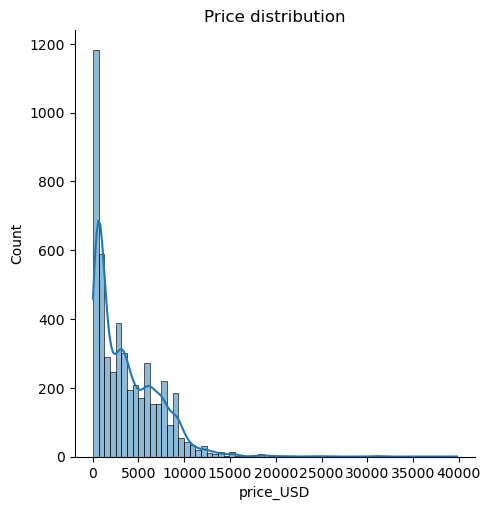

In [204]:
# Price distribution
fig = sns.displot(df['price_USD'], kde=True).set(title='Price distribution')

## 2.2 Percentage distribution of the features prensence

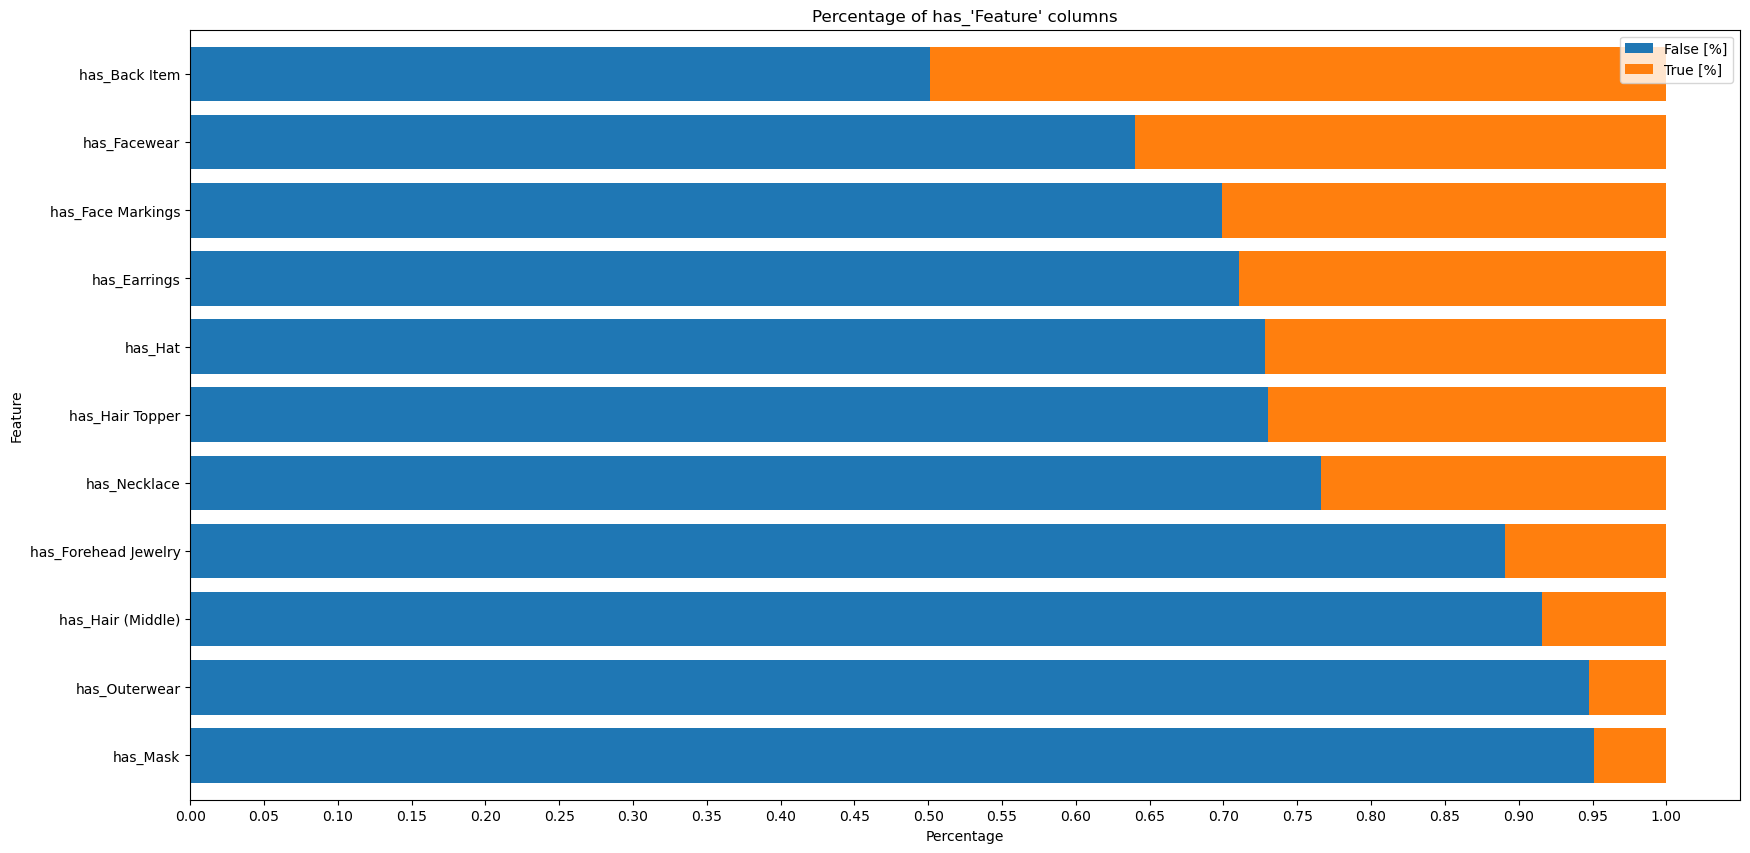

In [205]:
# Percentage of has_'Feature' columns plot 
# create temp array
temp = []
for col in df.columns:
    if col.startswith('has_'):
        temp.append([col,df[col].value_counts()[0]/len(df), df[col].value_counts()[1]/len(df)])

# create new dataframe
dfHasFeature = pd.DataFrame(temp, columns=['Name','False [%]', 'True [%]'])
# Order item 
dfHasFeature.sort_values(by=['True [%]'], inplace=True)

# Plot
plt = dfHasFeature.plot(kind='barh', stacked=True, figsize=(20,10), title='Percentage of has_\'Feature\' columns', x='Name', width=0.8)
plt.set_xlabel('Percentage')
plt.set_ylabel('Feature')

# Add more x ticks
plt.set_xticks(np.arange(0, 1.05, 0.05))


## 2.3 Percentage distribution of the features rarity
It is possible to see that the previous calculation of the rarity of the features is correct. The majority of the features have a small percentage of "Rare" values.

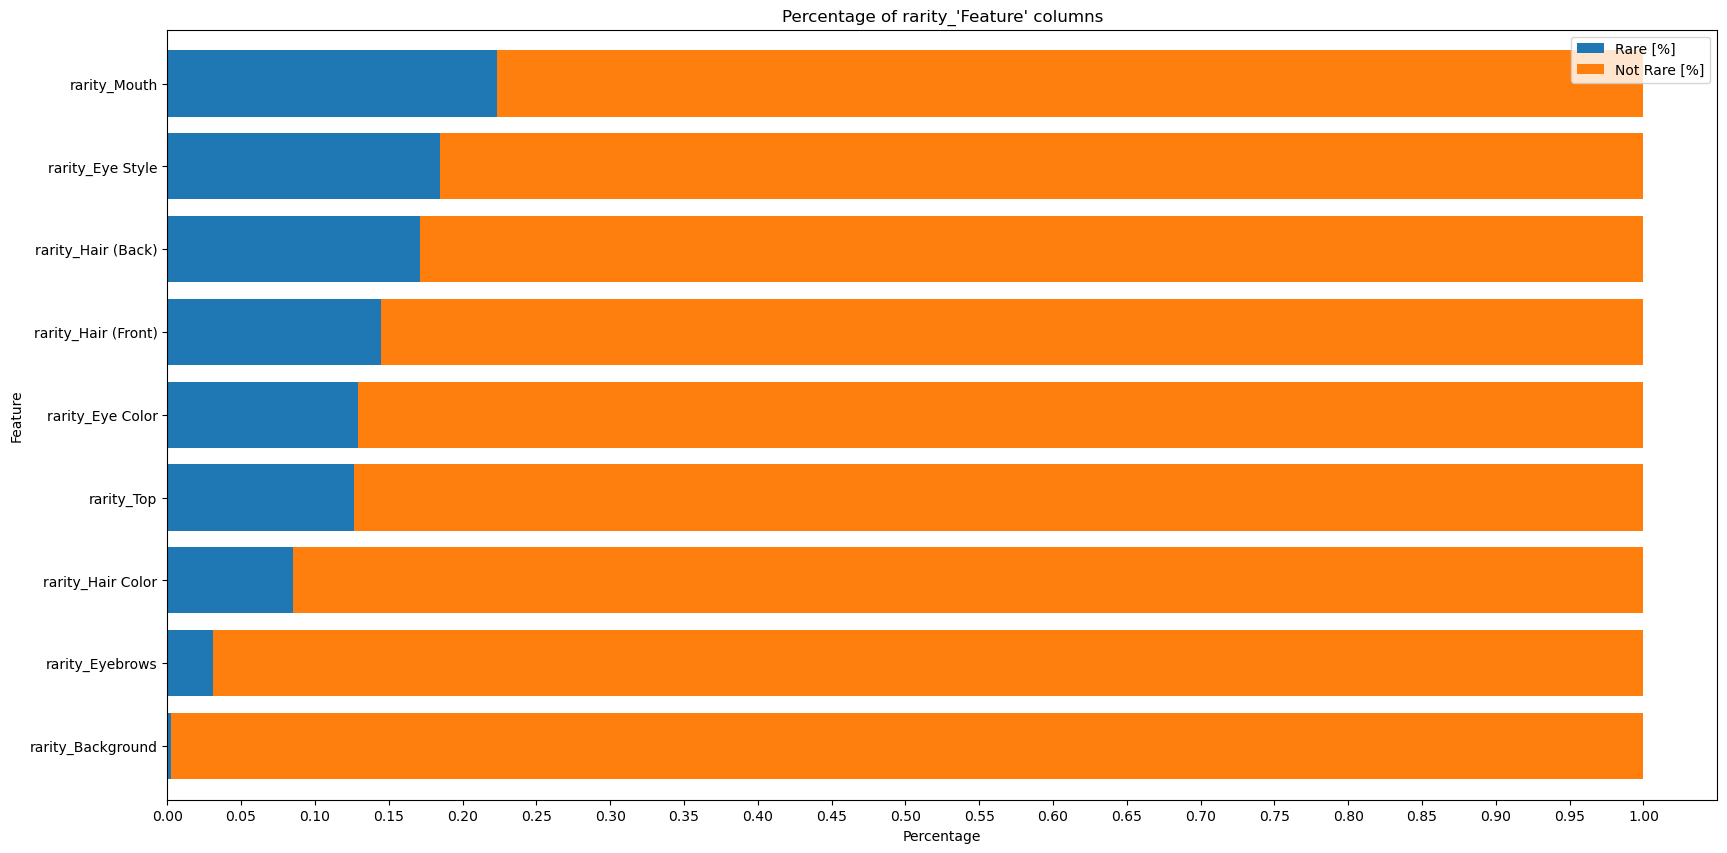

In [206]:
# Percentage of rarity_'Feature' columns plot 
# create temp array
temp = []
for col in df.columns:
    if col.startswith('rarity_'):
        if(len(df[col].value_counts()) == 1):
            if(df[col].value_counts().index[0] == 'Rare'):
                temp.append([col,df[col].value_counts()[0]/len(df), 0])
            else:
                temp.append([col,0, df[col].value_counts()[0]/len(df)])
        else:
            temp.append([col,df[col].value_counts()[1]/len(df), df[col].value_counts()[0]/len(df)])

# create new dataframe
dfHasFeature = pd.DataFrame(temp, columns=['Name','Rare [%]', 'Not Rare [%]'])
# Order item 
dfHasFeature.sort_values(by=['Rare [%]'], inplace=True)

# Plot
plt = dfHasFeature.plot(kind='barh', stacked=True, figsize=(20,10), title='Percentage of rarity_\'Feature\' columns', x='Name', width=0.8)
plt.set_xlabel('Percentage')
plt.set_ylabel('Feature')

# Add more x ticks
plt.set_xticks(np.arange(0, 1.05, 0.05))


## 2.3 Score distribution

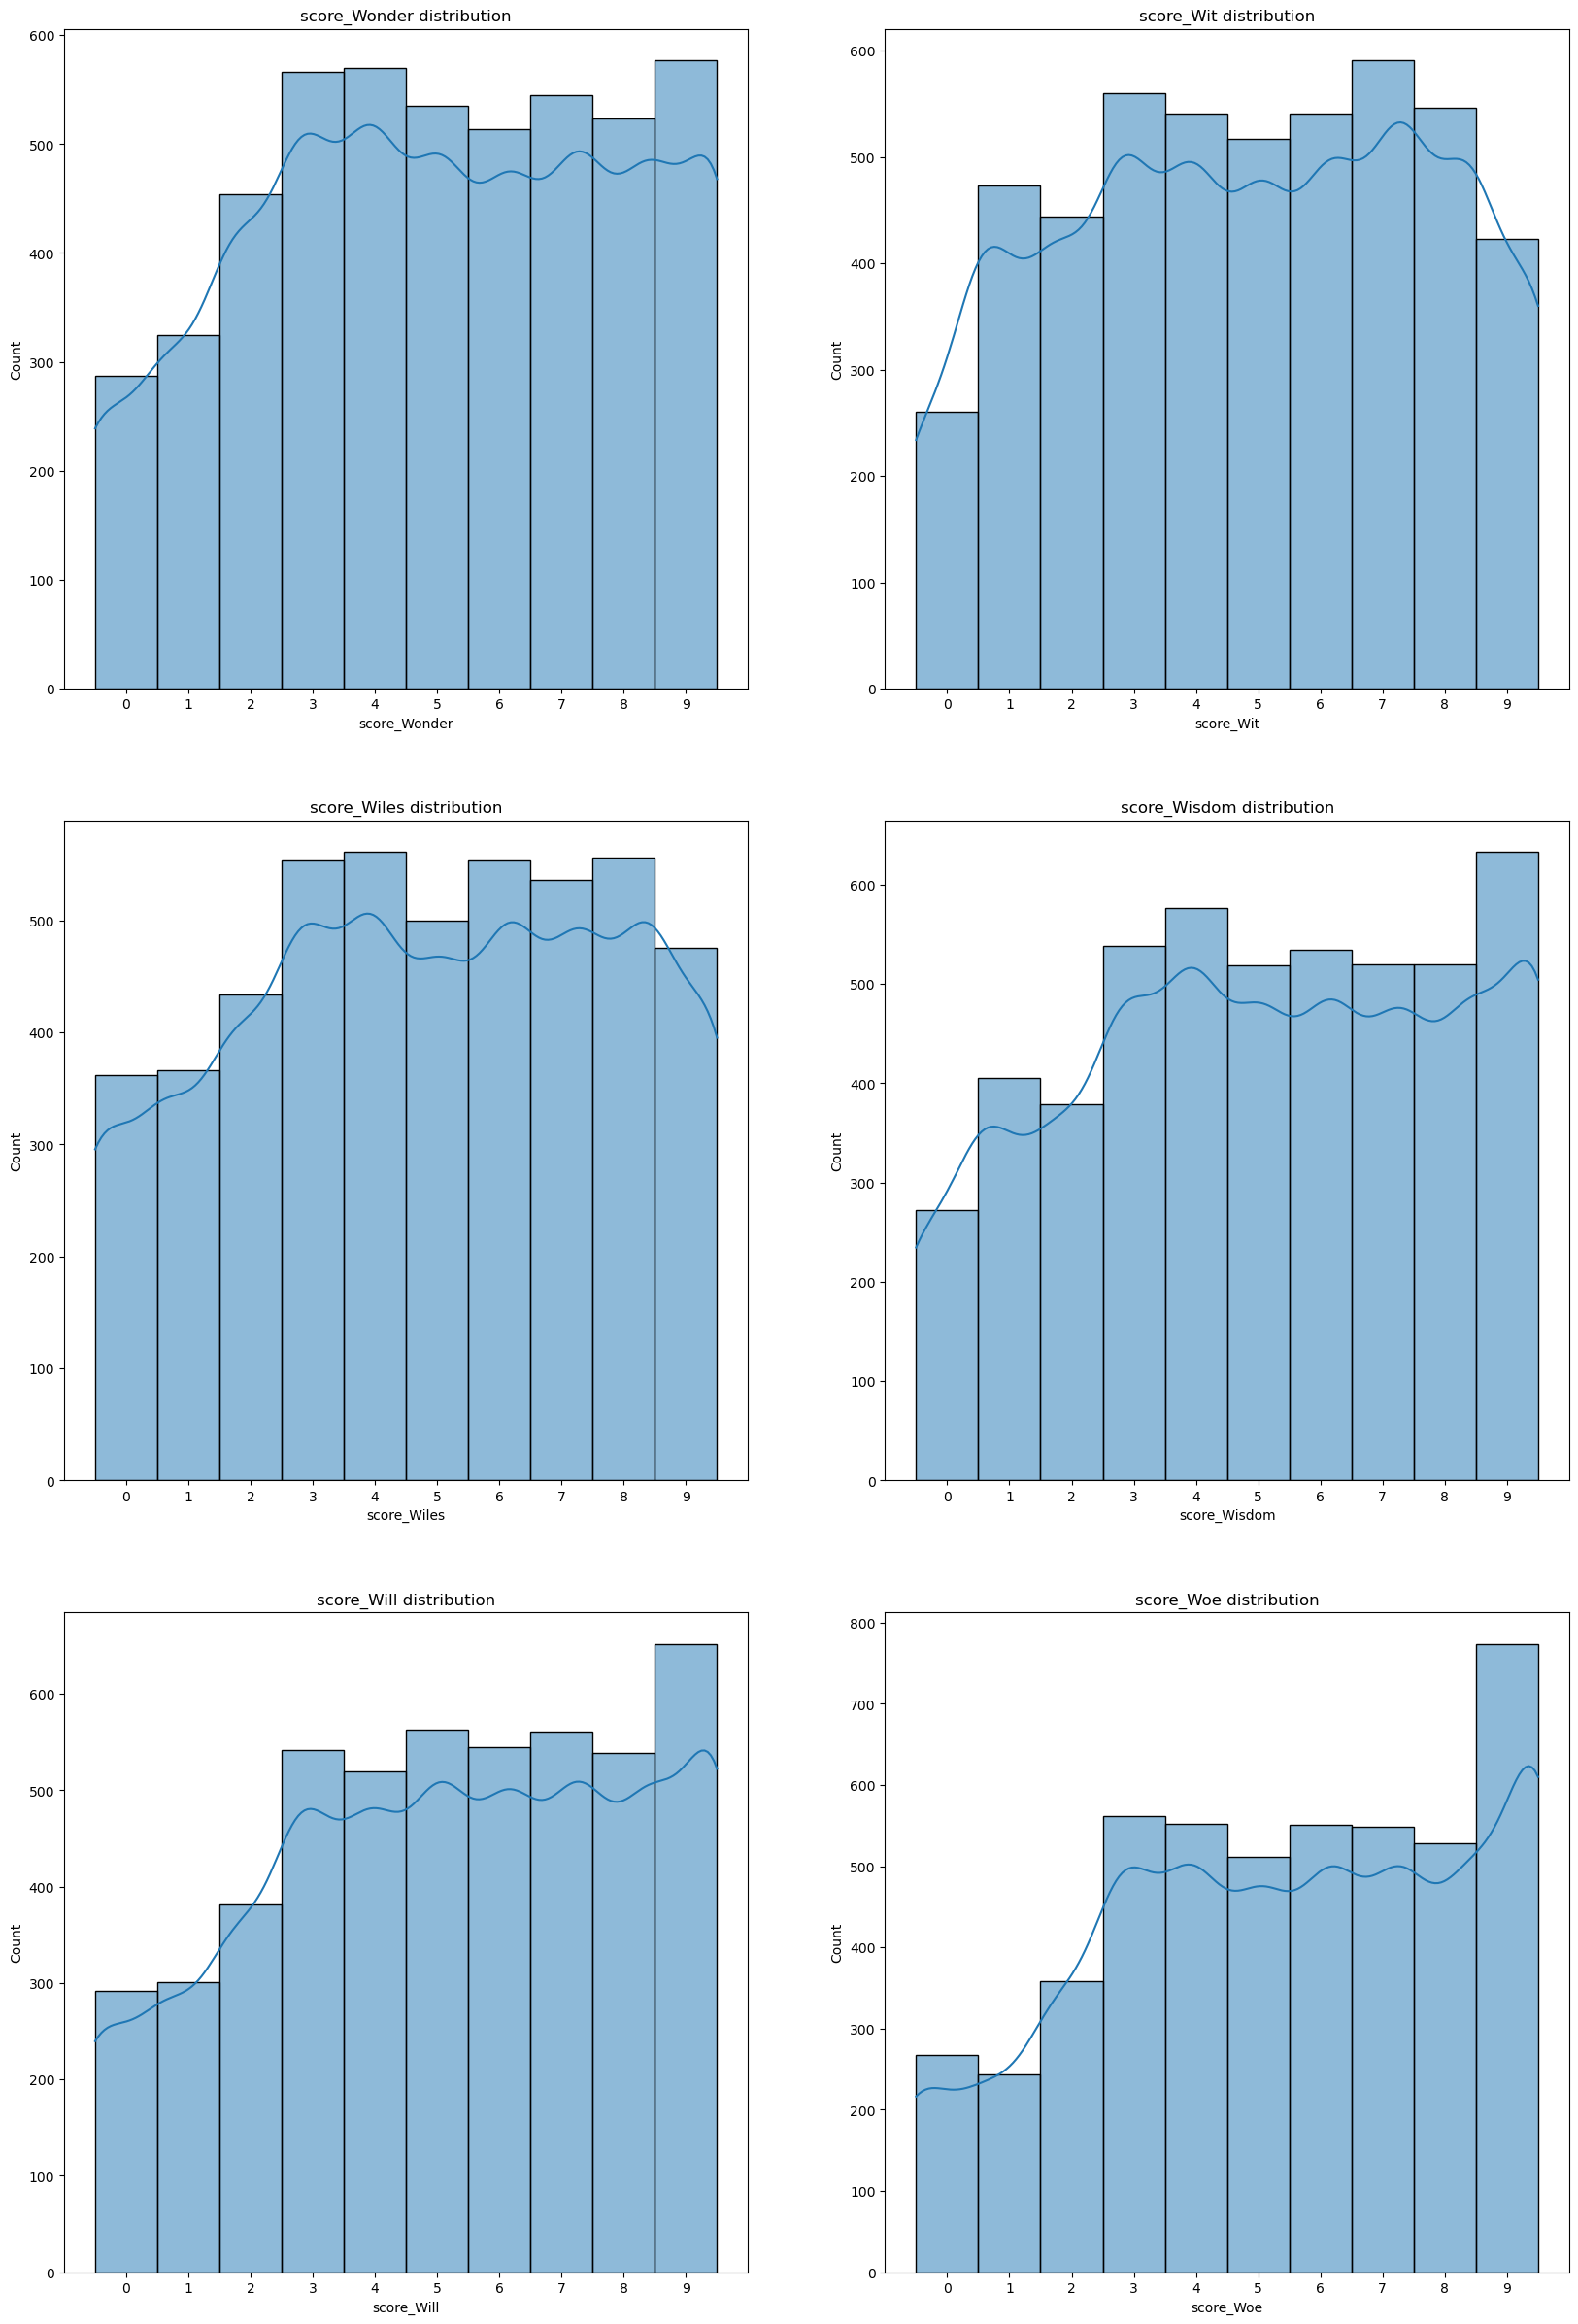

In [207]:
import matplotlib.pyplot as plt
# Distribution of 'score_' features

# create temp array
temp = []
for col in df.columns:
    if col.startswith('score_'):
        temp.append([col,df[col].mean(), df[col].median(), df[col].mode()[0], df[col].std()])

# Create subplots
height = int(len(temp)/2)
width = 2
fig, axs = plt.subplots(height, width, figsize=(10*width, 10*height))

for i in range(len(temp)):
    # Histogram
    max_n = df[temp[i][0]].max()
    min_n = df[temp[i][0]].min()
    bins = 10
    step = (max_n - min_n) / bins
    arr_div = np.arange(min_n + step / 2, max_n + step / 2, step=step)
    arr_div_r = np.round(arr_div, 0).astype(int)
    fig = sns.histplot(data = df, x=temp[i][0], kde=True, bins=bins, ax=axs[i%height,i%width]).set(title=f'{temp[i][0]} distribution')
    axs[i % height, i % width].set_xticks(arr_div)
    axs[i % height, i % width].set_xticklabels(arr_div_r)

plt.show()

## 2.4 Correlation matrix
As it is possible to see from the graph above, there is not a correlation between the features. This means that the features are independent.

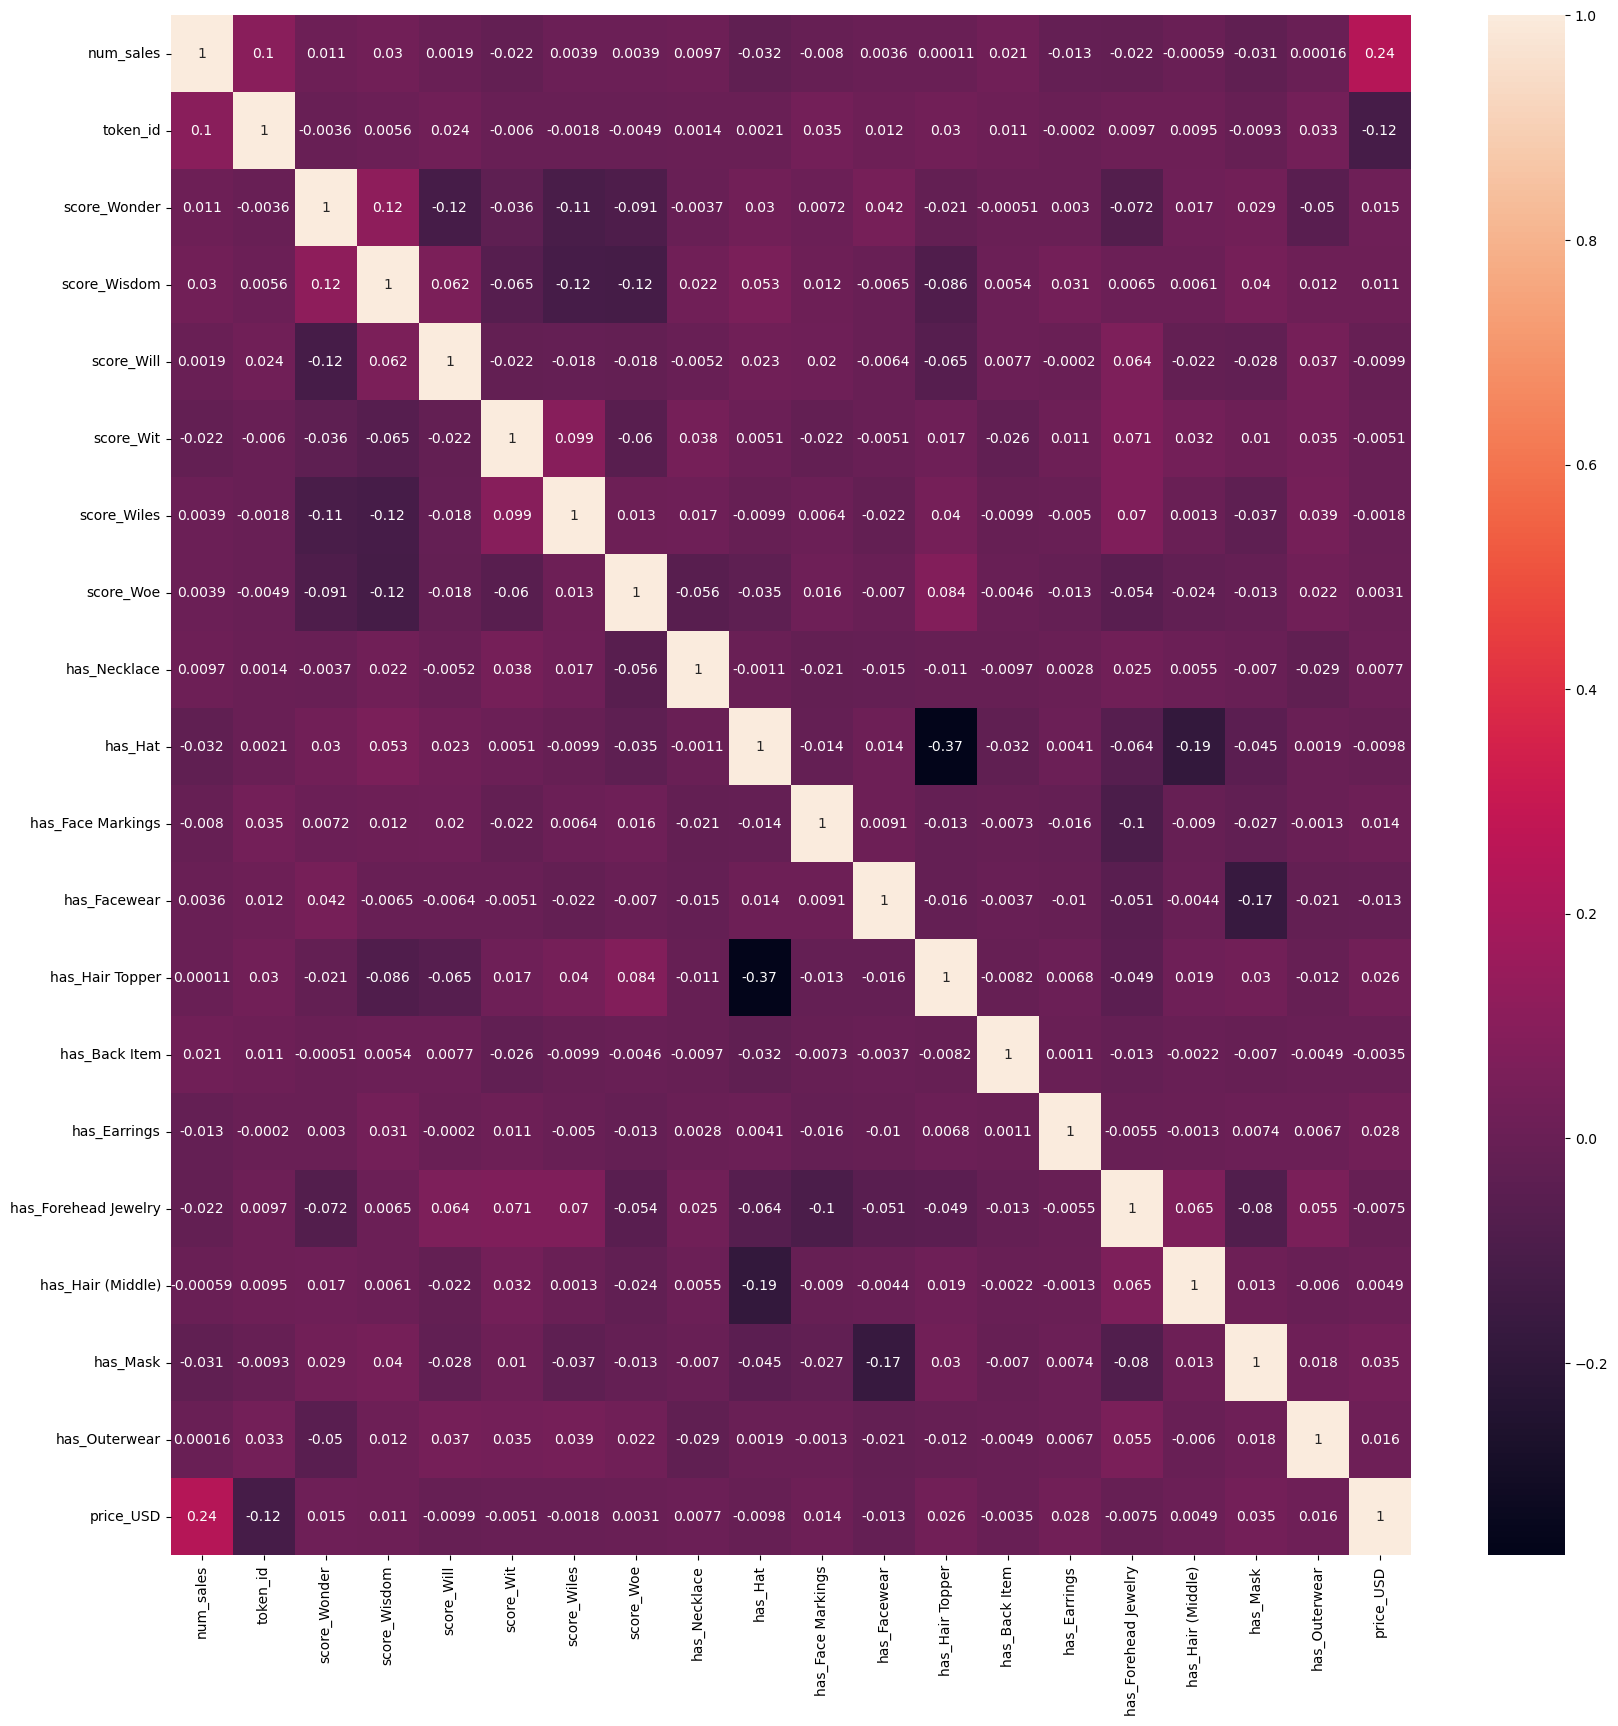

In [208]:
# Correlation matrix
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()

# 3. Price prediction model
The goal of this section is to create a model that can predict the price of a token based on the features of the token.
It will be done following these steps:
1. Split the dataset into train, validation and test set (60%, 20%, 20%) using K-Fold cross validation
2. LASSO regression with all the features. Some features will be removed from the model if they have a p-value > 0.05
3. RIDGE regression with the features selected in the previous step

**Note**: In this dataset is not needed to scale the features because the features are already scaled.

## 3.1 Convertion of the features in numeric values and dummy variables

In [209]:
# Conver binary columns to 0 and 1

# Create a list of columns to be converted
feature = []

for col in df.columns:
    if col.startswith('has_') or col.startswith('rarity_'):
        feature.append(col)

# if present, replace 'True' with 1 and 'False' with 0. If rare, replace 'Rare' with 1 and 'Not Rare' with 0
for col in feature:
    if col.startswith('has_'):
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)
    else:
        df[col] = df[col].apply(lambda x: 1 if x == 'Rare' else 0)

# It remains to convert the Body Shape feature with dummy variables
df = pd.get_dummies(df, columns=['Body Shape'], prefix = ['dummies_BodyShape'])

# Add to the list of features the dummy variables and the score features
for col in df.columns:
    if col.startswith('dummies_') or col.startswith('score_'):
        feature.append(col)

# Print dataset info
printDatasetInfo(df)
df.sample(1)

Total columns: 35
Columns names: num_sales, name, description, permalink, token_id, score_Wonder, rarity_Eyebrows, score_Wisdom, score_Will, rarity_Hair Color, score_Wit, score_Wiles, rarity_Eye Style, rarity_Eye Color, rarity_Mouth, score_Woe, rarity_Hair (Front), rarity_Top, rarity_Hair (Back), rarity_Background, has_Necklace, has_Hat, has_Face Markings, has_Facewear, has_Hair Topper, has_Back Item, has_Earrings, has_Forehead Jewelry, has_Hair (Middle), has_Mask, has_Outerwear, price_USD, dummies_BodyShape_Chiseled, dummies_BodyShape_Lithe, dummies_BodyShape_Soft, 
Columns type:


,Types,NaN Count,NaN %,Unique Values
num_sales,[<class 'int'>],0,0.0,9
name,[<class 'str'>],0,0.0,4895
description,[<class 'str'>],0,0.0,4895
permalink,[<class 'str'>],0,0.0,4895
token_id,[<class 'int'>],0,0.0,4895
score_Wonder,[<class 'int'>],0,0.0,10
rarity_Eyebrows,[<class 'int'>],0,0.0,2
score_Wisdom,[<class 'int'>],0,0.0,10
score_Will,[<class 'int'>],0,0.0,10
rarity_Hair Color,[<class 'int'>],0,0.0,2


,num_sales,name,description,permalink,token_id,score_Wonder,rarity_Eyebrows,score_Wisdom,score_Will,rarity_Hair Color,...,has_Back Item,has_Earrings,has_Forehead Jewelry,has_Hair (Middle),has_Mask,has_Outerwear,price_USD,dummies_BodyShape_Chiseled,dummies_BodyShape_Lithe,dummies_BodyShape_Soft
514,1,solarflare the charred,You are a WITCH enshrined in gilded power. You...,https://opensea.io/assets/0x5180db8f5c931aae63...,515,0,0,4,8,0,...,0,1,0,0,0,0,929.994,0,1,0


## 3.2 Split the dataset
Split the dataset into train, validation and test set (60%, 20%, 20%)

In [231]:
from sklearn.model_selection import train_test_split
# Split dataset in train, validation and test set

y = df['price_USD']
X = df.drop(['price_USD'], axis=1)
# Drop all columns not in the feature list
X = X[feature]

# Split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# *Note*: The validation set is split in the following code section with the GridSearchCV
# Split train set in train and validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## 3.3 LASSO regression

In [217]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Lasso regression
# Create the parameter grid based on the results of random search
param_grid = {
    'alpha': 10**np.linspace(10,-2,100)*0.5 ,
    'max_iter': [1000, 10000, 100000],
    'tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Create a based model
lasso = Lasso()

# Instantiate the grid search model
crossValidation = 5
lasso_regressor = GridSearchCV(estimator = lasso, param_grid = param_grid, cv = crossValidation, scoring='neg_mean_squared_error') 

# Fit the grid search to the data
lasso_regressor.fit(X_train, y_train)

# Print best parameters
print(f'Best params {lasso_regressor.best_params_}')
print(f'Best score {-lasso_regressor.best_score_}')

# Create a list of features with a coefficient different from 0
feature_lasso = []
for i in range(len(lasso_regressor.best_estimator_.coef_)):
    if lasso_regressor.best_estimator_.coef_[i] != 0:
        feature_lasso.append(feature[i])

# Print the number of features
print(f'Number of features: {len(feature_lasso)} that are important for the prediction')

# Print the features
print(f'Best features: {feature_lasso}')

c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+09, tolerance: 3.818e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+09, tolerance: 3.818e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Best params {'alpha': 4.055654153948428, 'max_iter': 1000, 'tol': 10}
Best score 11919007.533452814
Number of features: 26 that are important for the prediction
Best features: ['rarity_Eyebrows', 'rarity_Hair Color', 'rarity_Eye Style', 'rarity_Eye Color', 'rarity_Mouth', 'rarity_Hair (Front)', 'rarity_Top', 'rarity_Hair (Back)', 'rarity_Background', 'has_Necklace', 'has_Hat', 'has_Face Markings', 'has_Facewear', 'has_Hair Topper', 'has_Back Item', 'has_Earrings', 'has_Forehead Jewelry', 'has_Hair (Middle)', 'has_Mask', 'has_Outerwear', 'score_Wonder', 'score_Wisdom', 'score_Will', 'score_Wit', 'score_Wiles', 'score_Woe']


In [221]:
# Test the model
from sklearn.metrics import  r2_score

# Calculate mean squared error and R-squared
y_pred = lasso_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print results
print(f'R-squared: {r2}')

R-squared: -0.013709408757733632


,rarity_Eyebrows,rarity_Hair Color,rarity_Eye Style,rarity_Eye Color,rarity_Hair (Front),rarity_Top,rarity_Hair (Back),rarity_Background,has_Necklace,has_Hat,...,has_Outerwear,score_Wonder,score_Wisdom,score_Will,score_Wit,score_Wiles,score_Woe,dummies_BodyShape_Chiseled,dummies_BodyShape_Lithe,dummies_BodyShape_Soft
5624,0,0,1,0,0,0,1,0,0,0,...,0,4,6,7,1,2,9,0,1,0
8606,0,0,0,1,1,0,1,0,0,0,...,0,3,1,7,5,0,9,0,1,0
3289,0,0,0,0,0,0,0,0,0,1,...,0,4,5,8,1,8,4,0,0,1
2848,0,0,0,1,0,0,0,0,1,0,...,0,5,2,8,9,5,9,0,0,1
2377,0,0,0,1,0,0,0,0,0,0,...,0,6,1,2,8,9,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6998,0,0,0,0,0,0,0,0,0,0,...,0,6,2,9,9,7,4,1,0,0
6688,0,0,0,0,0,0,0,0,0,0,...,0,2,0,7,7,5,9,0,0,1
2581,0,0,1,0,0,0,0,0,1,1,...,0,7,3,9,2,8,2,1,0,0
8650,0,0,0,0,0,0,0,0,0,0,...,0,5,9,9,5,5,3,0,0,1


## 3.4 RIDGE regression
Using the features selected in the LASSO regression, it is possible to create a model that can predict the price of a token with a R2 score of XXX.

In [230]:
X_train

,rarity_Eyebrows,rarity_Hair Color,rarity_Eye Style,rarity_Eye Color,rarity_Hair (Front),rarity_Top,rarity_Hair (Back),rarity_Background,has_Necklace,has_Hat,...,has_Outerwear,score_Wonder,score_Wisdom,score_Will,score_Wit,score_Wiles,score_Woe,dummies_BodyShape_Chiseled,dummies_BodyShape_Lithe,dummies_BodyShape_Soft
5624,0,0,1,0,0,0,1,0,0,0,...,0,4,6,7,1,2,9,0,1,0
8606,0,0,0,1,1,0,1,0,0,0,...,0,3,1,7,5,0,9,0,1,0
3289,0,0,0,0,0,0,0,0,0,1,...,0,4,5,8,1,8,4,0,0,1
2848,0,0,0,1,0,0,0,0,1,0,...,0,5,2,8,9,5,9,0,0,1
2377,0,0,0,1,0,0,0,0,0,0,...,0,6,1,2,8,9,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6998,0,0,0,0,0,0,0,0,0,0,...,0,6,2,9,9,7,4,1,0,0
6688,0,0,0,0,0,0,0,0,0,0,...,0,2,0,7,7,5,9,0,0,1
2581,0,0,1,0,0,0,0,0,1,1,...,0,7,3,9,2,8,2,1,0,0
8650,0,0,0,0,0,0,0,0,0,0,...,0,5,9,9,5,5,3,0,0,1


In [232]:
from sklearn.linear_model import Ridge

# Ridge regression
# Create the parameter grid based on the results of random search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [1000, 10000, 100000],
    'tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Create new train and test set with only the important features
X_train = X_train[feature_lasso]
X_test = X_test[feature_lasso]

# Create a based model
ridge = Ridge()

# Instantiate the grid search model
crossValidation = 5
ridge_regressor = GridSearchCV(estimator = ridge, param_grid = param_grid, cv = crossValidation, scoring='neg_mean_squared_error')

# Fit the grid search to the data
ridge_regressor.fit(X_train, y_train)

# Print best parameters
print(f'Best params {ridge_regressor.best_params_}')
print(f'Best score {-ridge_regressor.best_score_}')

Best params {'alpha': 1, 'max_iter': 1000, 'tol': 0.0001}
Best score 11920536.239959676


In [233]:
# Test the model
from sklearn.metrics import  r2_score

# Calculate mean squared error and R-squared
ridge_regressor.fit(X_train, y_train)
y_pred = ridge_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print results
print(f'R-squared: {r2}')

R-squared: -0.01686962164998418


## 3.5 Random Forest regression

In [234]:
from sklearn.ensemble import RandomForestRegressor

# Random forest regression
# Create the parameter grid based on the results of random search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create new train and test set with only the important features
X_train = X_train[feature_lasso]
X_test = X_test[feature_lasso]

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
crossValidation = 5
rf_regressor = GridSearchCV(estimator = rf, param_grid = param_grid, cv = crossValidation, scoring='neg_mean_squared_error')

# Fit the grid search to the data
rf_regressor.fit(X_train, y_train)

# Print best parameters
print(f'Best params {rf_regressor.best_params_}')
print(f'Best score {-rf_regressor.best_score_}')



c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\ManueleNolli\miniconda3\envs\machine-learning\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

Best params {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score 11916115.344951645


In [235]:
# Make predictions on test data
y_pred = rf_regressor.predict(X_test)

# Calculate mean squared error and R-squared
r2 = r2_score(y_test, y_pred)

# Print results
print(f'R-squared: {r2}')

R-squared: -0.013507277298770326


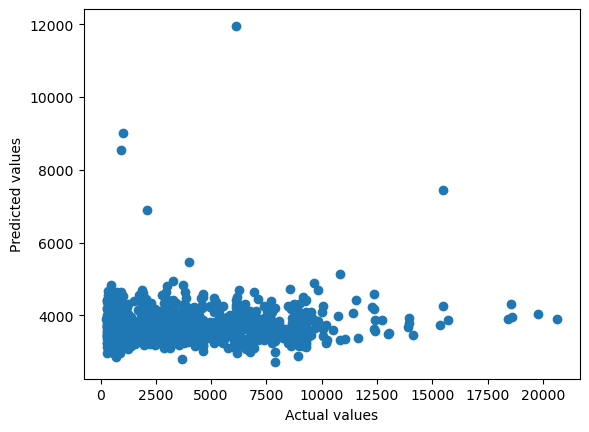

In [236]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


## Cross-validation K-fold

# Classification model